In [5]:
from torchvision.datasets import CIFAR10, CIFAR100, SVHN

# cifar10 = CIFAR10('../data/cifar10', train=True)
# cifar100 = CIFAR100('../data/cifar100', train=True)
svhn= SVHN('../data/SVHN', download=True)

ValueError: Unknown value 'val' for argument split. Valid values are {'train', 'test', 'extra'}.


64282624it [00:29, 4730331.25it/s]                              

In [16]:
import numpy as np

cifar10 = [(x / 127.5 - 1).astype(np.float32) for x in cifar10.data]

In [32]:
cifar10[0].transpose(2, 0, 1)

(3, 32, 32)

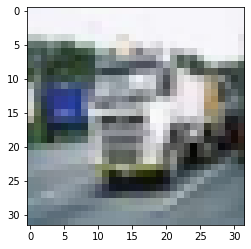

In [25]:
import matplotlib.pyplot as plt

plt.imshow(cifar10[1000] / 2 + 0.5)

In [10]:
from torchvision.datasets import MNIST

a = MNIST('../data/mnist', train=True)

In [13]:
(a.data[0] / 127.5 - 1).max()

tensor(1.)

In [26]:
(ds.data[0].numpy() / 127.5 - 1).astype(np.float32).reshape(-1).shape

(784,)

In [29]:
ds.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [21]:
import numpy as np
imgs = [(x.numpy() / 127.5 - 1).astype(np.float32).view(-1) for x in ds.data]

TypeError: data type not understood

In [1]:
import sys; sys.path.append('..')
from src.models.feat_vae import FeatVAE
from src.models.classifier import FeatClassifier
from src.dataloaders.load_data import load_data
from firelab.config import Config
import numpy as np
import numpy as np
import torch
import torch.nn.functional as F

DEVICE = 'cuda'

In [2]:
config = Config.load('../configs/lat_gm_vae.yml', frozen=False)
config.all.hp.model.set('pretrained', True)
config.all.hp.model.set('num_classes', 200)
# config = config.overwrite(Config({'all': {'hp': {'model': {'learn_prior' : True}}}}))
config.all.hp.model.learn_prior = True
base_conf = Config.load('../configs/base.yml')
base_conf = base_conf.overwrite(Config({'cub_embeddings': {'data': {'dir': "../data/CUB_EMBEDDINGS"}}}))

In [3]:
from torch.utils.data import DataLoader

train_ds, test_ds, attrs = load_data(base_conf.cub_embeddings.data)

# train_imgs = np.array([d[0] for d in train_ds])
# train_imgs /= np.abs(train_imgs).max(axis=0, keepdims=True)
# train_imgs -= train_imgs.mean(axis=0, keepdims=True)

# test_imgs = np.array([d[0] for d in test_ds])
# test_imgs /= np.abs(train_imgs).max(axis=0, keepdims=True)
# test_imgs -= train_imgs.mean(axis=0, keepdims=True)

# train_ds = [(train_imgs[i], train_ds[i][1]) for i in range(len(train_ds))]
# test_ds = [(test_imgs[i], test_ds[i][1]) for i in range(len(test_ds))]

train_ds = [(np.tanh(x), y) for x, y in train_ds]
test_ds = [(np.tanh(x), y) for x, y in test_ds]

train_dataloader = DataLoader(train_ds, batch_size=600, shuffle=True, collate_fn=lambda b: list(zip(*b)))
test_dataloader = DataLoader(test_ds, batch_size=600, shuffle=False, collate_fn=lambda b: list(zip(*b)))

Loading train_feats_resnet18.npy
Loading test_feats_resnet18.npy


In [4]:
NUM_CLASSES = 200

def compute_prototype(ds, label: int):
    return np.mean([x for x, y in ds if y == label], axis=0)

prototypes = np.array([compute_prototype(train_ds, y) for y in range(NUM_CLASSES)])
prototypes = torch.from_numpy(prototypes).to(DEVICE)

In [23]:
def validate_vae(vae_model, dataloader):
    rec_losses = []
    kl_losses = []

    with torch.no_grad():
        for x, y in dataloader:
            x = torch.tensor(x).to(DEVICE)
            y = torch.tensor(y).to(DEVICE)

            z_mean, z_logvar = vae_model.encoder(x, y)
            z_prior_mean, z_prior_logvar = vae_model.prior(y)
            z = vae_model.sample(z_mean, z_logvar)
            x_rec = vae_model.decoder(z, y)

            rec_loss = F.mse_loss(x_rec, x, reduction='none').mean(dim=1)
            kl_loss = compute_kl_loss(z_mean, z_logvar, z_prior_mean, z_prior_logvar, reduction=None)

            rec_losses.extend(rec_loss.cpu().tolist())
            kl_losses.extend(kl_loss.cpu().tolist())

    return np.mean(rec_losses), np.mean(kl_losses)


def group_by_class(X, y):
    groups = [[]] * NUM_CLASSES
    
    for x, y in zip(X, y):
        groups[y].append(x)
        
    return [(torch.stack(g) if len(g) else torch.empty(0)) for g in groups]

In [30]:
# config = config.overwrite(Config({'all': {'hp': {'model': {'z_dim' : 512}}}}))
vae = FeatVAE(config.all.hp.model).to(DEVICE)

In [31]:
from src.utils.losses import compute_kld_between_diagonal_gaussians as compute_kl_loss

optim = torch.optim.Adam(vae.parameters(), lr=1e-4)
max_num_epochs = 50
beta = 1.
proto_loss_coef = 100.
train_rec_loss_history = []
train_kl_loss_history = []


for epoch in range(max_num_epochs):
    for x, y in train_dataloader:
        x = torch.tensor(x).to(DEVICE)
        y = torch.tensor(y).to(DEVICE)
        
        z_mean, z_logvar = vae.encoder(x, y)
        z_prior_mean, z_prior_logvar = vae.prior(y)
        z = vae.sample(z_mean, z_logvar, noise_level=epoch/max_num_epochs)
        x_rec = vae.decoder(z, y)
        
        rec_loss = F.mse_loss(x_rec, x)
        kl_loss = compute_kl_loss(z_mean, z_logvar, z_prior_mean, z_prior_logvar)
        
        proto_loss = F.mse_loss(x_rec, prototypes[y])
        x_rec_groups = group_by_class(x_rec, y)
        #proto_losses = [(F.mse_loss(g.mean(dim=0), prototypes[y]) if len(g) else torch.zeros(1)) for g, y in zip(x_rec_groups, y)]
        #proto_loss = torch.stack(proto_losses).mean()

        total_loss = rec_loss + beta * kl_loss + proto_loss_coef * proto_loss
        
        optim.zero_grad()
        total_loss.backward()
        optim.step()
    
    val_rec_loss, val_kl_loss = validate_vae(vae, test_dataloader)
    
    if epoch % 10 == 0:
        print(f'[Epoch #{epoch:03d} T] rec: {rec_loss.item(): 0.4f}. KL: {kl_loss.item(): 0.4f}. P: {proto_loss.item(): 0.4f}')
        print(f'[Epoch #{epoch:03d} V] rec: {val_rec_loss.item(): 0.4f}. KL: {val_kl_loss.item(): 0.4f}')

[Epoch #000 T] rec:  0.1087. KL:  9.1582. P:  0.0784
[Epoch #000 V] rec:  0.0925. KL:  8.8618
[Epoch #010 T] rec:  0.0339. KL:  0.2318. P:  0.0049
[Epoch #010 V] rec:  0.0576. KL:  0.2250
[Epoch #020 T] rec:  0.0311. KL:  0.0351. P:  0.0020
[Epoch #020 V] rec:  0.0443. KL:  0.0376
[Epoch #030 T] rec:  0.0328. KL:  0.0139. P:  0.0014
[Epoch #030 V] rec:  0.0359. KL:  0.0143
[Epoch #040 T] rec:  0.0304. KL:  0.0076. P:  0.0010
[Epoch #040 V] rec:  0.0324. KL:  0.0081


In [5]:
import torch.nn.functional as F
from src.models.feat_gan import FeatGenerator, FeatDiscriminator

gan_config = Config.load('../configs/lat_gm.yml', frozen=False)
gan_config.all.hp.model.set('pretrained', True)
gan_config.all.hp.model.set('num_classes', 200)
gan_config.all.hp.model.use_attrs_in_gen = False
gan_config.all.hp.model.use_attrs_in_discr = False
gan_config.all.hp.model.cls_hid_dim = 1024
# gan_config.all.hp.model.hid_dim = 2048
gan_config.all.hp.model.share_body_in_discr = True


def compute_proto_loss(x, prototypes) -> torch.Tensor:
    assert len(x) % len(prototypes) == 0
    
    prototypes = torch.from_numpy(prototypes) \
        .repeat(len(x) // len(prototypes), 1) \
        .to(DEVICE)
    
    return F.mse_loss(x, prototypes)


def generator_step(gen, discr, optim_gen, x, prototypes, cls_gen_coef:float=1., proto_loss_coef:float=1., gen_batch_size = 1000):
    z = gen.sample_noise(gen_batch_size).to(DEVICE)
    y = torch.arange(NUM_CLASSES).repeat(gen_batch_size // NUM_CLASSES).to(DEVICE)
    x_fake = gen(z, y)
    adv_logits, cls_logits = discr(x_fake)
    adv_loss = -adv_logits.mean()
    cls_loss = F.cross_entropy(cls_logits, y)
    cls_acc = (cls_logits.argmax(dim=1) == y).float().mean().detach().cpu()
    #proto_loss = proto_loss_coef * F.mse_loss(x_fake, torch.from_numpy(prototypes[y]).to(DEVICE))
    proto_loss = compute_proto_loss(x_fake, prototypes)
    
    total_loss = adv_loss + cls_gen_coef * cls_loss + proto_loss_coef + proto_loss
    
    optim_gen.zero_grad()
    total_loss.backward()
    optim_gen.step()
    
    return adv_loss, cls_acc, proto_loss
    
    
def discriminator_step(gen, discr, optim_discr, x, y, gp_coef:float=10.,
                       cls_discr_coef:float=1., cls_adv_loss_coef:float=1.):
    with torch.no_grad():
        z = gen.sample_noise(y.size(0)).to(DEVICE)
        x_fake = gen(z, y) # TODO: try picking y randomly

    adv_logits_on_real, cls_logits_on_real = discr(x)
    adv_logits_on_fake, cls_logits_on_fake = discr(x_fake)

    adv_loss = -adv_logits_on_real.mean() + adv_logits_on_fake.mean()
    grad_penalty = compute_gradient_penalty(discr.run_adv_head, x, x_fake)
    
    cls_loss = F.cross_entropy(cls_logits_on_real, y)
    cls_acc = (cls_logits_on_real.argmax(dim=1) == y).float().mean().detach().cpu()
    
    # Cross-entropy with uniform dist
    #cls_adv_loss = (cls_logits_on_fake.logsumexp(dim=1) - cls_logits_on_fake.sum(dim=1) / NUM_CLASSES).mean()
    cls_adv_loss = F.kl_div(cls_logits_on_fake.log_softmax(dim=1), torch.ones_like(cls_logits_on_fake) / cls_logits_on_fake.shape[1])
    #cls_adv_loss = -F.cross_entropy(cls_logits_on_fake, y)
    
    #if cls_adv_loss.abs() > 10:
    #    cls_adv_loss = (cls_adv_loss / cls_adv_loss.abs().detach()) * 10

    total_loss = adv_loss + gp_coef * grad_penalty + cls_discr_coef * cls_loss + cls_adv_loss_coef * cls_adv_loss
    
    optim_discr.zero_grad()
    total_loss.backward()
    optim_discr.step()

    return adv_loss, grad_penalty, cls_acc, cls_adv_loss

In [6]:
gen = FeatGenerator(gan_config.all.hp.model).to(DEVICE)
discr = FeatDiscriminator(gan_config.all.hp.model).to(DEVICE)

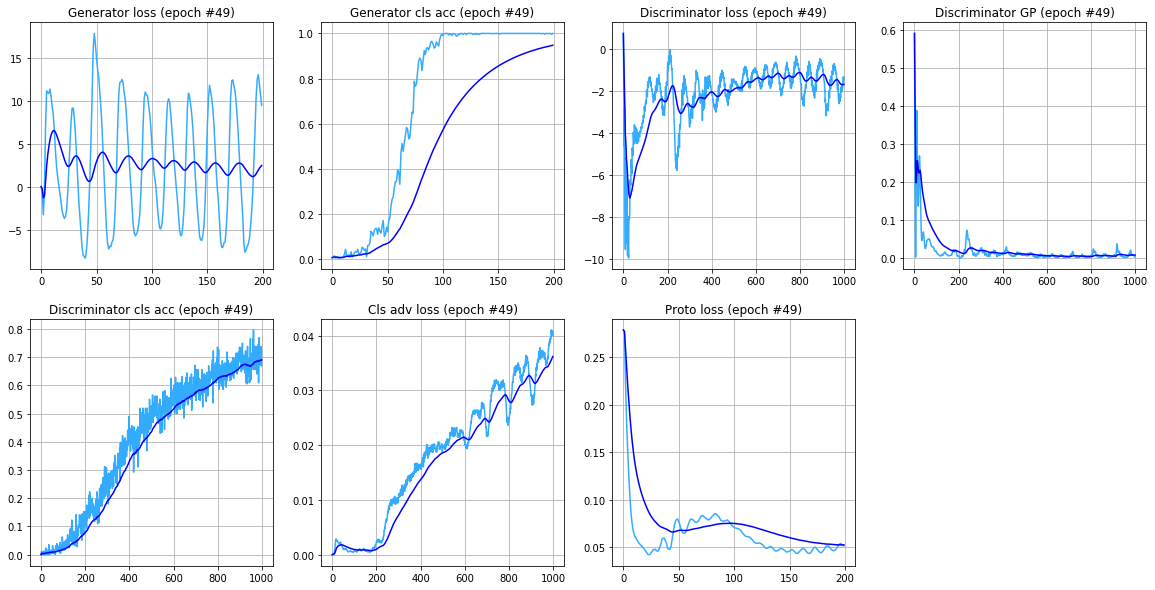

In [7]:
import math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline

from src.utils.losses import compute_gradient_penalty

optim_gen = torch.optim.Adam(gen.parameters())
optim_discr = torch.optim.Adam(discr.parameters())
max_num_epochs = 50
num_discr_steps = 5
cls_discr_coef = 1.
cls_adv_loss_coef = 10.

num_iters_done = 0
gen_adv_losses_hist = []
gen_cls_acc_hist = []
discr_adv_losses_hist = []
gp_hist = []
discr_cls_acc_hist = []
cls_adv_loss_hist = []
proto_loss_hist = []
plot_every_epoch = 1


for epoch in range(max_num_epochs):
    for x, y in train_dataloader:
        x = torch.tensor(x).to(DEVICE)
        y = torch.tensor(y).to(DEVICE)
        
        if num_iters_done % (num_discr_steps + 1) == 0:
            gen_adv_loss, gen_cls_acc, proto_loss = generator_step(
                gen, discr, optim_gen, x, prototypes)
            
            gen_adv_losses_hist.append(gen_adv_loss.detach().cpu().item())
            gen_cls_acc_hist.append(gen_cls_acc.item())
            proto_loss_hist.append(proto_loss.detach().cpu().item())
        else:
            discr_adv_loss, grad_penalty, discr_cls_acc, cls_adv_loss = discriminator_step(
                gen, discr, optim_discr, x, y, cls_discr_coef=cls_discr_coef, cls_adv_loss_coef=cls_adv_loss_coef)
            
            discr_adv_losses_hist.append(discr_adv_loss.detach().cpu().item())
            gp_hist.append(grad_penalty.detach().cpu().item())
            discr_cls_acc_hist.append(discr_cls_acc.item())
            cls_adv_loss_hist.append(cls_adv_loss.detach().cpu().item())
            
        num_iters_done += 1
            
    if epoch % plot_every_epoch == 0:
        clear_output(True)
        plt.figure(figsize=[20,10])

        plt.subplot(241)
        plt.title(f"Generator loss (epoch #{epoch})")
        plt.plot(gen_adv_losses_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(gen_adv_losses_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()
        
        plt.subplot(242)
        plt.title(f"Generator cls acc (epoch #{epoch})")
        plt.plot(gen_cls_acc_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(gen_cls_acc_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()

        plt.subplot(243)
        plt.title(f"Discriminator loss (epoch #{epoch})")
        plt.plot(discr_adv_losses_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(discr_adv_losses_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()

        plt.subplot(244)
        plt.title(f"Discriminator GP (epoch #{epoch})")
        plt.plot(gp_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(gp_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()
        
        plt.subplot(245)
        plt.title(f"Discriminator cls acc (epoch #{epoch})")
        plt.plot(discr_cls_acc_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(discr_cls_acc_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()
        
        plt.subplot(246)
        plt.title(f"Cls adv loss (epoch #{epoch})")
        plt.plot(cls_adv_loss_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(cls_adv_loss_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()
        
        plt.subplot(247)
        plt.title(f"Proto loss (epoch #{epoch})")
        plt.plot(proto_loss_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(proto_loss_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()

        plt.show()

In [32]:
def validate_clf(clf_model, dataloader):
    losses = []
    accs = []

    with torch.no_grad():
        for x, y in dataloader:
            x = torch.tensor(x).to(DEVICE)
            y = torch.tensor(y).to(DEVICE)

            logits = clf_model(x)
            loss = F.cross_entropy(logits, y, reduction='none').cpu().tolist()
            acc = (logits.argmax(dim=1) == y).float().cpu().tolist()
            
            losses.extend(loss)
            accs.extend(acc)
        
    return np.mean(losses), np.mean(accs)

In [34]:
import random

clf = FeatClassifier(config.all.hp.model).to(DEVICE)
optim = torch.optim.Adam(clf.parameters(), lr=1e-3)
max_num_steps = 1000
batch_size = 256

for step in range(max_num_steps):
    with torch.no_grad():
        y = random.choices(range(200), k=batch_size)
        y = torch.tensor(y).to(DEVICE)
        #x = gen.sample(y)
        x = vae.generate(y)
        
    logits = clf(x)
    loss = F.cross_entropy(logits, y)
    acc = (logits.argmax(dim=1) == y).float().mean().cpu().detach()
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if step % 100 == 0:
        val_loss, val_acc = validate_clf(clf, test_dataloader)

        print(f'[Step #{step:04d}] Train loss: {loss.item(): 0.4f}. Train acc: {acc.item(): 0.4f}')
        print(f'[Step #{step:04d}] Val loss  : {val_loss.item(): 0.4f}. Val acc  : {val_acc.item(): 0.4f}')
        
print('Train loss/acc:', validate_clf(clf, train_dataloader))

[Step #0000] Train loss:  5.3063. Train acc:  0.0000
[Step #0000] Val loss  :  5.3069. Val acc  :  0.0059
[Step #0100] Train loss:  3.8669. Train acc:  0.2891
[Step #0100] Val loss  :  4.1777. Val acc  :  0.1072
[Step #0200] Train loss:  1.8550. Train acc:  0.8008
[Step #0200] Val loss  :  3.4355. Val acc  :  0.2176
[Step #0300] Train loss:  0.9650. Train acc:  0.9336
[Step #0300] Val loss  :  3.6183. Val acc  :  0.2472
[Step #0400] Train loss:  0.4365. Train acc:  0.9922
[Step #0400] Val loss  :  4.0623. Val acc  :  0.2504
[Step #0500] Train loss:  0.2785. Train acc:  1.0000
[Step #0500] Val loss  :  4.4750. Val acc  :  0.2565
[Step #0600] Train loss:  0.1614. Train acc:  1.0000
[Step #0600] Val loss  :  4.8870. Val acc  :  0.2542
[Step #0700] Train loss:  0.1079. Train acc:  1.0000
[Step #0700] Val loss  :  5.2492. Val acc  :  0.2584
[Step #0800] Train loss:  0.0897. Train acc:  1.0000
[Step #0800] Val loss  :  5.5402. Val acc  :  0.2547
[Step #0900] Train loss:  0.0706. Train acc:  

In [32]:
vae.prior.model(vae.prior.embedder(y))

tensor([[-0.0205,  0.0907, -0.0357,  ...,  0.0055, -0.0262,  0.0615],
        [-0.0040,  0.0930, -0.0491,  ...,  0.0789,  0.0038,  0.0873],
        [-0.0053,  0.0885, -0.0278,  ...,  0.0084,  0.0053,  0.1047],
        ...,
        [ 0.0091,  0.1011, -0.0184,  ...,  0.0557,  0.0033,  0.0751],
        [ 0.0383,  0.1043, -0.0466,  ...,  0.0814, -0.0044,  0.0737],
        [ 0.0317,  0.0740, -0.0656,  ...,  0.0203, -0.0071,  0.1984]],
       grad_fn=<AddmmBackward>)

In [41]:
clf = FeatClassifier(config.all.hp.model).to(DEVICE)
optim = torch.optim.Adam(clf.parameters(), lr=1e-3)
max_num_epochs = 100

for epoch in range(max_num_epochs):
    for x, y in train_dataloader:
        x = torch.tensor(x).to(DEVICE)
        y = torch.tensor(y).to(DEVICE)

        logits = clf(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean().cpu().detach()

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    if epoch % 10 == 0:
        val_loss, val_acc = validate_clf(clf, test_dataloader)
        
        print(f'[Epoch #{epoch:04d}] Train loss: {loss.item(): 0.4f}. Train acc: {acc.item(): 0.4f}')
        print(f'[Epoch #{epoch:04d}] Val loss  : {val_loss.item(): 0.4f}. Val acc  : {val_acc.item(): 0.4f}')

[Epoch #0000] Train loss:  5.2211. Train acc:  0.0283
[Epoch #0000] Val loss  :  5.1892. Val acc  :  0.0307


KeyboardInterrupt: 